# Ships in Satellite Imagery

## 0. Importing libraries

In [1]:
import json, sys, random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD
import keras.callbacks
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt
from random import randint
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

Using TensorFlow backend.


## 1. Reading the data

In [2]:
fships = open('./shipsnet.json')
dataset = json.load(fships)
fships.close()
pships = pd.DataFrame(dataset)
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
print ('Size of the data:', x.shape)
print('Number of Ship Images: {}'.format(np.sum(y==1)))
print('Number of NoShip Images: {}'.format(np.sum(y==0)))

Size of the data: (4000, 19200)
Number of Ship Images: 1000
Number of NoShip Images: 3000


## 2. Displaying the header

In [3]:
pships.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


## 3. Reshaping the data

In [4]:
X = x.reshape ([-1, 3, 80, 80])
print ('Shape of the input: ', X.shape)
Y = to_categorical(y, num_classes=2)
print ('Shape of the output: ', Y.shape)

Shape of the input:  (4000, 3, 80, 80)
Shape of the output:  (4000, 2)


## 4. Visualizing the color spectrums

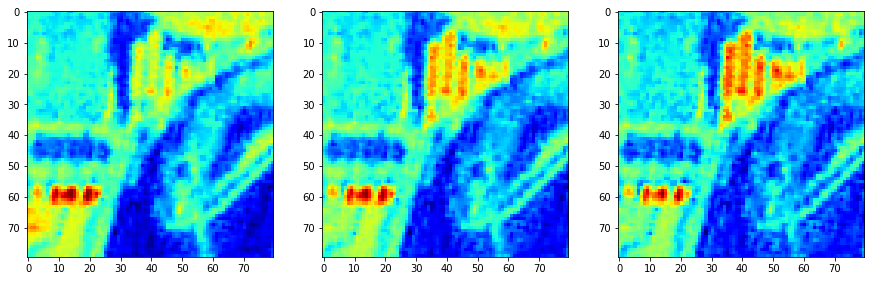

In [5]:
spectrum = X[randint(0, X.shape[0])]

plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')
plt.subplot(1, 3, 1)
plt.imshow(spectrum[0])
plt.subplot(1, 3, 2)
plt.imshow(spectrum[1])
plt.subplot(1, 3, 3)
plt.imshow(spectrum[2])  
plt.show()

## 5. Splitting and normalizing the data

In [6]:

# shuffle all indexes
indexes = np.arange(4000)
np.random.shuffle(indexes)
X_train = X[indexes].transpose([0,2,3,1])
y_train = Y[indexes]

# normalization
X_train = X_train / 255

In [7]:

from sklearn.model_selection import train_test_split
auto_train_X,auto_valid_X,auto_train_ground,auto_valid_ground = train_test_split(X_train,
                                                                 y_train,
                                                                 test_size=0.0,
                                                                 random_state=13)

## 6. Training the convolutional autoencoder

In [8]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

batch_size = 64
epochs = 18
inChannel = 3
x, y = 80, 80
input_img = Input(shape = (x, y, inChannel))
num_classes = 10


def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

autoencoder = Model(input_img, decoder(encoder(input_img)))
encoder_model = Model(input_img, encoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [9]:
train_X,valid_X,train_ground,valid_ground = train_test_split(auto_train_X,
                                                             auto_train_X,
                                                             test_size=0.2,
                                                             random_state=13)


encoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 3200 samples, validate on 800 samples
Epoch 1/18
3200/3200 [==============================] - 18s 6ms/step - loss: 0.0201 - val_loss: 0.1918
Epoch 2/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0086 - val_loss: 0.0588
Epoch 3/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0061 - val_loss: 0.0656
Epoch 4/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0047 - val_loss: 0.0449
Epoch 5/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0041 - val_loss: 0.0456
Epoch 6/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0035 - val_loss: 0.0532
Epoch 7/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0030 - val_loss: 0.0258
Epoch 8/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0035 - val_loss: 0.0103
Epoch 9/18
3200/3200 [==============================] - 10s 3ms/step - loss: 0.0029 - val_loss: 0.0325
Epoch 10/18
3200/3200 [===

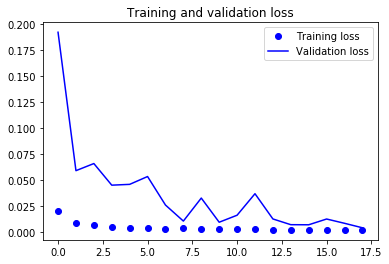

In [10]:
loss = encoder_train.history['loss']
val_loss = encoder_train.history['val_loss']
epochs = range(18)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 7. Encoding the original imagery

In [11]:
enc_trainX = encoder_model.predict(X_train)

## 8. Training the convolutional neural network predictor

In [12]:
np.random.seed(7)

# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(20, 20, 256), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [13]:
# optimization setup
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
model.fit(
    enc_trainX, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 3200 samples, validate on 800 samples
Epoch 1/18
 - 7s - loss: 0.5744 - acc: 0.7475 - val_loss: 0.5613 - val_acc: 0.7512
Epoch 2/18
 - 5s - loss: 0.5642 - acc: 0.7497 - val_loss: 0.5611 - val_acc: 0.7512
Epoch 3/18
 - 5s - loss: 0.5628 - acc: 0.7497 - val_loss: 0.5610 - val_acc: 0.7512
Epoch 4/18
 - 5s - loss: 0.5640 - acc: 0.7497 - val_loss: 0.5611 - val_acc: 0.7512
Epoch 5/18
 - 5s - loss: 0.5631 - acc: 0.7497 - val_loss: 0.5620 - val_acc: 0.7512
Epoch 6/18
 - 5s - loss: 0.5646 - acc: 0.7497 - val_loss: 0.5613 - val_acc: 0.7512
Epoch 7/18
 - 5s - loss: 0.5631 - acc: 0.7497 - val_loss: 0.5610 - val_acc: 0.7512
Epoch 8/18
 - 5s - loss: 0.5619 - acc: 0.7497 - val_loss: 0.5614 - val_acc: 0.7512
Epoch 9/18
 - 5s - loss: 0.5633 - acc: 0.7497 - val_loss: 0.5617 - val_acc: 0.7512
Epoch 10/18
 - 5s - loss: 0.5641 - acc: 0.7497 - val_loss: 0.5615 - val_acc: 0.7512
Epoch 11/18
 - 5s - loss: 0.5636 - acc: 0.7497 - val_loss: 0.5610 - val_acc: 0.7512
Epoch 12/18
 - 5s - loss: 0.5645 - acc